# Evaluando con Embedding para comparar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score

import nltk
import string
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tiefa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### **Lectura del Dataset**

In [2]:
# Lectura del dataset
df = pd.read_csv('tweets_hate_speech.csv')
# Vista de los datos
df.head()

,tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive


#### **Preprocesamiento ligero de Textos**

In [3]:
def clean_for_embedding(text):
    text = text.lower()
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

df['clean_text'] = df['tweet'].apply(clean_for_embedding)

In [4]:
df['clean_text']

0         rt mayasolovely as a woman you shouldnt compl...
1         rt mleew17 boy dats coldtyga dwn bad for cuff...
2         rt urkindofbrand dawg rt 80sbaby4life you eve...
3           rt cganderson vivabased she look like a tranny
4         rt shenikaroberts the shit you hear about me ...
                               ...                        
24778    yous a muthafin lie 8220lifeasking 20pearls co...
24779    youve gone and broke the wrong heart baby and ...
24780    young buck wanna eat dat nigguh like i aint fu...
24781                youu got wild bitches tellin you lies
24782    ruffled  ntac eileen dahlia  beautiful color c...
Name: clean_text, Length: 24783, dtype: object

#### **Procesamiento de variable de salida**

In [5]:
# Convertir sentimiento a números
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])  # Guarda el target como número

In [6]:
df['label'].value_counts()

label
2    19190
1     4163
0     1430
Name: count, dtype: int64

In [7]:
y = df['label']

#### **Generar Embeddings**

In [8]:
model = SentenceTransformer('all-MiniLM-L6-v2')
X_embed = model.encode(df['clean_text'], show_progress_bar=True)

Batches:   0%|          | 0/775 [00:00<?, ?it/s]

In [9]:
X_embed.shape

(24783, 384)

In [10]:
X_embed

array([[ 0.01901864,  0.00712657,  0.07876877, ..., -0.02855344,
        -0.01802498, -0.0662341 ],
       [-0.16165811,  0.09571908,  0.0073463 , ...,  0.0361587 ,
        -0.07018037, -0.03525419],
       [-0.09051607, -0.03429916,  0.05277705, ...,  0.03487894,
         0.07084113, -0.08789101],
       ...,
       [-0.07719656,  0.00237438, -0.00057759, ...,  0.05092219,
         0.01416581, -0.0707811 ],
       [ 0.01163934, -0.04132041,  0.03148473, ...,  0.02136753,
        -0.02645826, -0.08492611],
       [-0.06784629, -0.04085307,  0.02901089, ...,  0.04269483,
         0.0034777 , -0.06179452]], dtype=float32)

#### **Balance del conjunto de datos**

<Axes: xlabel='count', ylabel='label'>

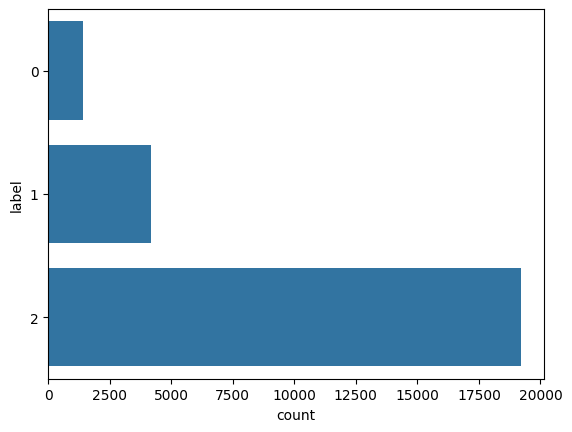

In [11]:
sns.countplot(data=df, y=y)

In [12]:
# SMOTE para balancear ambos conjuntos de datos
smote = SMOTE()

# Para embeddings
X_res, y_res = smote.fit_resample(X_embed, y)

<Axes: xlabel='count', ylabel='label'>

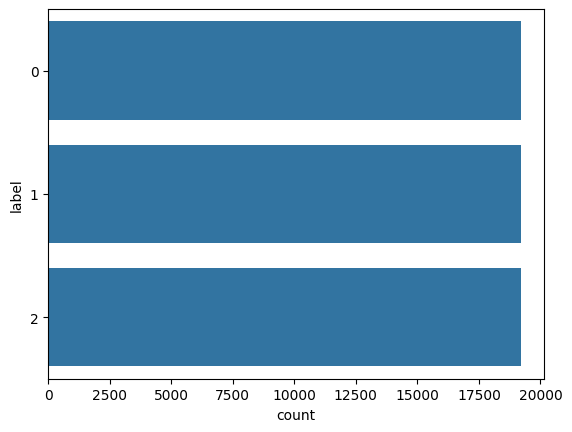

In [14]:
sns.countplot(y=y_res)

#### **División dataset en train/test**

In [15]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3)

#### **Definir modelos de AA**

In [16]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": GaussianNB()
}

#### **Entrenar y evaluar modelos**

In [17]:
# Guardar los resultados
resultados_accuracy = []

def evaluate_models(X_train, X_test, y_train, y_test, vectorizer_name):
    print(f"\n Resultados con {vectorizer_name}:\n" + "-"*40)
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"\n Modelo: {name}")
        print("Accuracy:", acc)
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

         # Guardar en la lista global
        resultados_accuracy.append({
            'Modelo': name,
            'Vectorización': vectorizer_name,
            'Accuracy': acc
        })

In [18]:
# Evaluar 
evaluate_models(X_train, X_test, y_train, y_test, "Embedding")


 Resultados con Embedding:
----------------------------------------

 Modelo: Logistic Regression
Accuracy: 0.8280933356493544
              precision    recall  f1-score   support

        hate       0.81      0.79      0.80      5804
     neither       0.87      0.92      0.89      5785
   offensive       0.80      0.78      0.79      5682

    accuracy                           0.83     17271
   macro avg       0.83      0.83      0.83     17271
weighted avg       0.83      0.83      0.83     17271


 Modelo: Random Forest
Accuracy: 0.9512477563545828
              precision    recall  f1-score   support

        hate       0.97      0.98      0.97      5804
     neither       0.94      0.97      0.95      5785
   offensive       0.95      0.91      0.93      5682

    accuracy                           0.95     17271
   macro avg       0.95      0.95      0.95     17271
weighted avg       0.95      0.95      0.95     17271


 Modelo: Naive Bayes
Accuracy: 0.7956690405882694
      

#### **Resultados**

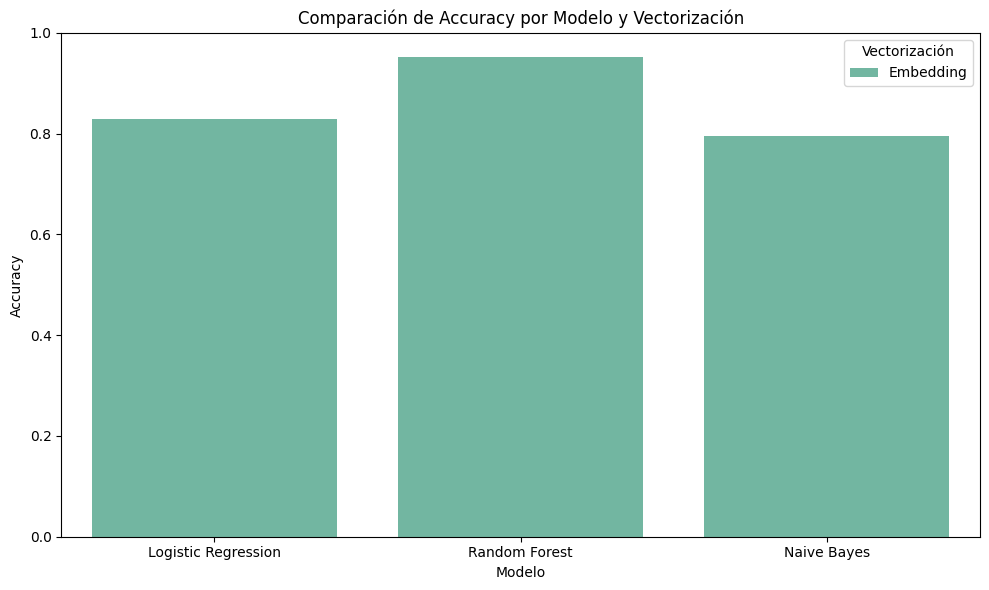

In [19]:
df_results = pd.DataFrame(resultados_accuracy)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x='Modelo', y='Accuracy', hue='Vectorización', palette='Set2')
plt.title('Comparación de Accuracy por Modelo y Vectorización')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()